#BEAN-LEAF-DISEASE-PREDICTION (TRANSFER LEARNING (VGG16))
##Dataset : TensorFlow

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt

#Data download

In [2]:
(ds_train, ds_validation, ds_test), ds_info = tfds.load(
    "beans",
    split=["train", "validation", "test"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incompleteU8FZ6E/beans-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incompleteU8FZ6E/beans-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incompleteU8FZ6E/beans-test.tfrecord


Dataset beans downloaded and prepared to /root/tensorflow_datasets/beans/0.1.0. Subsequent calls will reuse this data.


In [3]:
print(ds_info)

tfds.core.DatasetInfo(
    name='beans',
    version=0.1.0,
    description='Beans is a dataset of images of beans taken in the field using smartphone
cameras. It consists of 3 classes: 2 disease classes and the healthy class.
Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated
by experts from the National Crops Resources Research Institute (NaCRRI) in
Uganda and collected by the Makerere AI research lab.',
    homepage='https://github.com/AI-Lab-Makerere/ibean/',
    features=FeaturesDict({
        'image': Image(shape=(500, 500, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=1295,
    splits={
        'test': 128,
        'train': 1034,
        'validation': 133,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {beansdata,
        author="Makerere AI Lab",
        title="Bean disease dataset",
        month="January",
        year="2020",
        url="https://git

In [4]:
print(ds_train)
print(ds_validation)
print(ds_test)

<_OptionsDataset shapes: ((500, 500, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((500, 500, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((500, 500, 3), ()), types: (tf.uint8, tf.int64)>


#Configure the dataset for performance

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = 224
BATCH_SIZE = 16
NUM_CLASSES = ds_info.features['label'].num_classes

In [6]:
def normalize_img(image, label):    
    return tf.cast(image, tf.float32) / 255.0, label

In [7]:
def resize_img(image, label):
    new_height = new_width = IMAGE_SIZE
    image = tf.image.resize(image, (new_height, new_width))

    return image, label

In [8]:
def augment_img(image, label):    
    image = tf.image.random_flip_left_right(image)  #horizontal flip
    image = tf.image.random_flip_up_down(image) #vertical flip

    return image, label

In [9]:
#setup for training dataset
ds_train_2 = ds_train.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_train_2 = ds_train_2.cache()
ds_train_2 = ds_train_2.shuffle(ds_info.splits["train"].num_examples)
ds_train_2 = ds_train_2.map(resize_img, num_parallel_calls=AUTOTUNE)
ds_train_2 = ds_train_2.map(augment_img, num_parallel_calls=AUTOTUNE)
ds_train_2 = ds_train_2.batch(BATCH_SIZE)
ds_train_2 = ds_train_2.prefetch(AUTOTUNE)

In [10]:
#setup for validation dataset
ds_validation_2 = ds_validation.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_validation_2 = ds_validation_2.map(resize_img, num_parallel_calls=AUTOTUNE)
ds_validation_2 = ds_validation_2.batch(BATCH_SIZE)
ds_validation_2 = ds_validation_2.prefetch(AUTOTUNE)

In [11]:
#setup for test dataset
ds_test_2 = ds_test.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_test_2 = ds_test_2.map(resize_img, num_parallel_calls=AUTOTUNE)
ds_test_2 = ds_test_2.batch(BATCH_SIZE)
ds_test_2 = ds_test_2.prefetch(AUTOTUNE)

In [12]:
print(ds_train_2)
print(ds_validation_2)
print(ds_test_2)

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>
<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>
<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>


#Building the model

##Base model (VGG16)

In [13]:
#create the base model from the pre-trained VGG16 model with ANN part removed
vgg16 = VGG16(input_shape=[IMAGE_SIZE]+[IMAGE_SIZE]+[3],
              weights='imagenet',
              include_top=False)

#freeze the convolutional base
for layer in vgg16.layers:
  layer.trainable = False

#base model summary
vgg16.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

##Our layers (ANN)

In [14]:
X = keras.layers.Flatten()(vgg16.output)  #I/P layer
HL = keras.layers.Dense(256, activation='relu', kernel_initializer='he_uniform')(X)  #Hidden layer
DPL = keras.layers.Dropout(0.5)(HL)  #Dropout layer
Y = keras.layers.Dense(NUM_CLASSES, activation='softmax')(DPL) #Output layer

##Base model (VGG16) + Our layers (ANN)

In [15]:
#create a model object
model_vgg16 = keras.Model(inputs=vgg16.input, outputs=Y)

#compiling the model
model_vgg16.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

#view the structure of the model
model_vgg16.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

#Training Phase

In [16]:
model_vgg16_history = model_vgg16.fit(
    x=ds_train_2,    
    epochs=50,
    validation_data=ds_validation_2    
)

Epoch 1/50
65/65 [==============================] - 47s 151ms/step - loss: 3.6609 - accuracy: 0.4775 - val_loss: 0.6194 - val_accuracy: 0.7368
Epoch 2/50
65/65 [==============================] - 5s 81ms/step - loss: 0.6826 - accuracy: 0.6948 - val_loss: 0.5127 - val_accuracy: 0.8271
Epoch 3/50
65/65 [==============================] - 5s 84ms/step - loss: 0.6101 - accuracy: 0.7154 - val_loss: 0.4996 - val_accuracy: 0.7669
Epoch 4/50
65/65 [==============================] - 5s 85ms/step - loss: 0.5018 - accuracy: 0.7759 - val_loss: 0.4946 - val_accuracy: 0.8045
Epoch 5/50
65/65 [==============================] - 6s 85ms/step - loss: 0.5025 - accuracy: 0.7768 - val_loss: 0.4432 - val_accuracy: 0.8421
Epoch 6/50
65/65 [==============================] - 5s 83ms/step - loss: 0.4647 - accuracy: 0.7980 - val_loss: 0.4733 - val_accuracy: 0.7895
Epoch 7/50
65/65 [==============================] - 5s 82ms/step - loss: 0.4993 - accuracy: 0.7926 - val_loss: 0.4782 - val_accuracy: 0.8120
Epoch 8/50


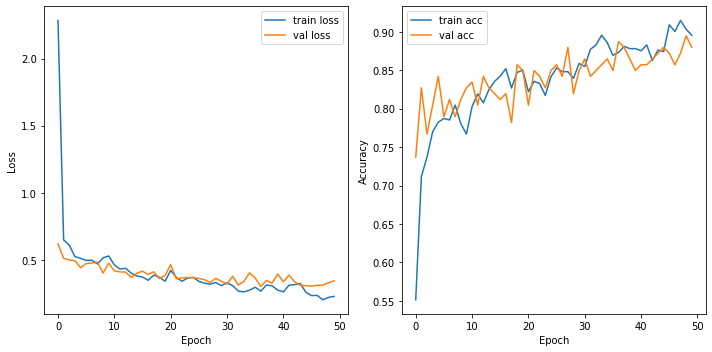

In [17]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(model_vgg16_history.history['loss'], label='train loss')
plt.plot(model_vgg16_history.history['val_loss'], label='val loss')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.subplot(1,2,2)
plt.plot(model_vgg16_history.history['accuracy'], label='train acc')
plt.plot(model_vgg16_history.history['val_accuracy'], label='val acc')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

In [18]:
loss, accuracy = model_vgg16.evaluate(ds_test_2)
print('Test accuracy :', accuracy)

8/8 [==============================] - 1s 70ms/step - loss: 0.3651 - accuracy: 0.8594
Test accuracy : 0.859375
